# Assessing SMEs' GDPR-compliance Through Privacy Policies: A Machine Learning Approach 
The goal of this research is to explore--using natural language processing and machine learning techniques--how organisations differ in their approach towards GDPR-compliance. We intend to do this by assessing privacy policies on their *focus* (rather than completeness) of the GDPR user rights and explore whether there is a correlation with the corresponding organisation's meta-data (e.g., country, service, data-driven). This will give us insight in organisations' interpretation of the GDPR (e.g., stressing a specific part) and factors (e.g., company size) that contribute to this particular interpretation.


#### Approach
read data -> stratified split -> preprocessing -> vectorizing -> random upsampling of training data -> train classification model -> save model and vectorizer -> classify collected datasets from Orbis Europe

---
## DATASET ##
This manually labeled set comprises 250 individual policies, containing over 18,300 natural sentences. For legal reasons, we have anonymized the data set, e.g. we have scrambled all num- bers and substituted names, email addresses, companies and URLs with generic replacements (e.g. ‘company 42645’). <br>
Source: __On GDPR Compliance of Companies’ Privacy Policies__ _by Müller et al._

The five GDPR requirements chosen to evaluate privacy policy compliance:

|No.|	Category|Required content in privacy policy|
|:---:|:---|:---|
|1| DPO | Contact details for the data protection officer or equivalent |
|2| Purpose | Disclosure of the purpose for which personal data is or is not used for |
|3| Acquired data | Disclosure that personal data is or is not collected, and/or which data is collected |
|4| Data sharing | Disclosure if 3rd parties can or cannot access a user’s personal data |
|5| Rights | Disclosure of the user’s right to rectify or erase personal data |

## Import labeled PPs (18.397 sentence snippets)

In [1]:
import pandas

# Let's load the training data from a csv file
dataset = pandas.read_csv('data/PP/GDPR.csv', sep='\t', encoding='utf-8')
dataset

,Text,DPO,Purpose,Acquired data,Data sharing,Rights
0,this is a privacy statement disclosing our inf...,0,0,0,0,0
1,"any other information that we gather, in pursu...",0,0,0,0,0
2,in such circumstances we will continue to send...,0,0,0,0,0
3,the information is not accessible to the publi...,0,0,0,1,0
4,company_32782 ltd will use your personal data ...,0,1,0,0,0
...,...,...,...,...,...,...
18392,you agree that we have the right to share your...,0,0,0,1,0
18393,"in some cases, we may need to share your perso...",0,0,0,1,0
18394,the site includes an online tool which you can...,0,0,0,0,0
18395,that information is provided directly to the t...,0,0,0,0,0


#### Explore balance of dataset
Source: https://towardsdatascience.com/multi-label-text-classification-with-scikit-learn-30714b7819c5

Text(0.5, 0, 'GDPR Assessment Criteria')

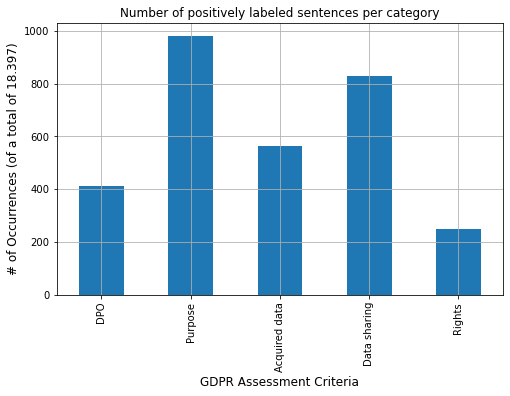

In [2]:
import matplotlib.pyplot as plt

categ = list(dataset.columns)[1:] # select all except 'text' column

counts = []
for column in categ:
#     print(dataset[column].value_counts())
    tmp_count = dataset[column].value_counts()
    # make a list of tuples that contain column name and number of pos labeled sentences     
    counts.append((column, tmp_count[1]))

df_stats = pandas.DataFrame(counts, columns=['GDPR_criteria', 'number_of_pos_sen'])

df_stats.plot(x='GDPR_criteria', y='number_of_pos_sen', kind='bar', legend=False, grid=True, figsize=(8, 5))
plt.title("Number of positively labeled sentences per category")
plt.ylabel('# of Occurrences (of a total of 18.397)', fontsize=12)
plt.xlabel('GDPR Assessment Criteria', fontsize=12)

#### What is the number of multi-labeled sentences?
Source: https://towardsdatascience.com/multi-label-text-classification-with-scikit-learn-30714b7819c5

C:\Users\aaberkan\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 0, '# of GDPR criteria')

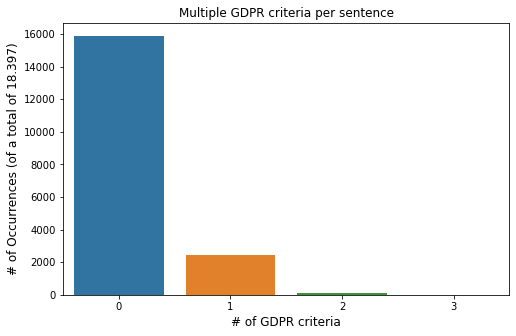

In [3]:
import seaborn as sns
rowsums = dataset.iloc[:,2:].sum(axis=1)
x=rowsums.value_counts()
#plot
plt.figure(figsize=(8,5))
ax = sns.barplot(x.index, x.values)
plt.title("Multiple GDPR criteria per sentence")
plt.ylabel('# of Occurrences (of a total of 18.397)', fontsize=12)
plt.xlabel('# of GDPR criteria', fontsize=12)

- The vast majority of the sentences is not labeled at all (almost 16.000)

#### Class imbalance, possible solutions:
- oversampling minority class
    - Resample function from scikit-learn packaged: randomly duplicate examples in the minority class.
    - generating synthetic samples using SMOTE functionality in Imblearn package
- undersampling majority class

##### Oversampling should be done on the training set only:
In class imbalance settings, artificially balancing the test/validation set does not make any sense: these sets must remain realistic, i.e. you want to test your classifier performance in the real world setting, where, say, the negative class will include the 99% of the samples, in order to see how well your model will do in predicting the 1% positive class of interest without too many false positives. Artificially inflating the minority class or reducing the majority one will lead to performance metrics that are unrealistic, bearing no real relation to the real world problem you are trying to solve.

Max Kuhn, creator of the caret R package and co-author of the (highly recommended) Applied Predictive Modelling textbook, in Chapter 11: Subsampling For Class Imbalances of the caret ebook:

__You would never want to artificially balance the test set; its class frequencies should be in-line with what one would see “in the wild”.__

Re-balancing makes sense only in the training set, so as to prevent the classifier from simply and naively classifying all instances as negative for a perceived accuracy of 99%.

Hence, you can rest assured that in the setting you describe the rebalancing takes action only for the training set/folds._

sources: 
- https://imbalanced-learn.org/stable/over_sampling.html
- https://stackoverflow.com/questions/48805063/balance-classes-in-cross-validation/48810493#48810493


#### Oversampling

In [4]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler
      
def oversample_data(x, y):    
    oversample = RandomOverSampler(sampling_strategy='minority', random_state = 42)
    x_over, y_over = oversample.fit_resample(x, y)
    return x_over, y_over

# print(Counter(y))

#### Preprocessing

In [19]:
from nltk.stem import PorterStemmer
# from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re

def preprocessing(pps):
#     tokenizer = nlp.tokenizer
    # tokenize sentences
    tokenized_sent = [sent.split() for sent in pps]
    
    # remove punctuation
    tokenized_sent = [[re.sub('[,’\'\.!?&“”():*_;"]', '', y) for y in x] for x in tokenized_sent]
    
    # remove words with numbers in them
    tokenized_sent = [[y for y in x if not any(c.isdigit() for c in y)] for x in tokenized_sent]
    
    # remove stopwords   
    tokenized_sent_clean = tokenized_sent
#     tokenized_sent_clean = [[y for y in x if y not in stopwords.words('english')] for x in tokenized_sent]
    
    # from nltk.stem import PorterStemmer
    porter = PorterStemmer()
    tokenized_sent_clean = [[porter.stem(y) for y in x] for x in tokenized_sent_clean]
    
#     lemmatizer = WordNetLemmatizer()
#     tokenized_sent_clean = [[lemmatizer.lemmatize(y) for y in x] for x in tokenized_sent_clean]

    
    detokenized_pps = []
    for i in range(len(tokenized_sent_clean)):
        t = ' '.join(tokenized_sent_clean[i])
        detokenized_pps.append(t) 
    
    return detokenized_pps

In [6]:
print("Before preprocessing: ")
print(dataset['Text'].to_list()[0:3])
print()
print("Post preprocessing: ")
print(preprocessing(dataset['Text'].to_list()[:3]))

Before preprocessing: 
['this is a privacy statement disclosing our information gathering, use and dissemination practices for the company_04614 web site.', 'any other information that we gather, in pursuance of the unpaid fee, including    information that is shared by you with us.', 'in such circumstances we will continue to send you service related communications which are non-marketing where necessary.']

Post preprocessing: 
['privaci statement disclos inform gather use dissemin practic web site', 'inform gather pursuanc unpaid fee includ inform share us', 'circumst continu send servic relat commun non-market necessari']


## Feature engineering

#### TF-IDF
<img src="img/tfidfformula.png">


#### TF-IDF Vectorizer
Convert a collection of raw documents to a matrix of TF-IDF features.
Equivalent to CountVectorizer followed by TfidfTransformer.
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

- fit (on training set): performs training (using training set)
- transform (on test set): changes the data in the pipeline in order to pass it on
- fit transform: both

## Train model - Classification: Logistic Regression

For classification tasks, Logistic regression models the probabability of an event occurring (e.g., "DPO", "Purpose") depending on the values of the independent variables, which are categorical (in our case even binary: "DPO" is 1 or 0).

We know that z is the weighted sum of the evidence for the class (probability of the class occurring).<br>


\begin{align}
z = c_0+c_1*𝑥_1+c_2*𝑥_2+...+c_𝑛*𝑥_𝑛
\end{align}

The larger the weight the greater impact the given feature has on the final decision:<br>
- large positive values indicate a positive impact (for the event to occur)
- large negative values indicate a negative impact (for the event not to occur)

Z value is between -∞ and +∞. 
Therefore we apply the sigmoid (or logistic function) to this value to obtain prob. values between 0 and 1.
The final probability scores let the model predict the label. If the prob of "Red" is higher than all other labels, the prediction will be "Red".

More info: https://machinelearningmastery.com/logistic-regression-for-machine-learning/

### Optimize parameters
#### TFIDF
___max_df___ float in range [0.0, 1.0] or int, default=1.0, is used for removing terms that appear too frequently, also known as "corpus-specific stop words". For example:
- max_df = 0.50 means "ignore terms that appear in more than 50% of the documents".
- max_df = 25 means "ignore terms that appear in more than 25 documents".
The default max_df is 1.0, which means "ignore terms that appear in more than 100% of the documents". Thus, the default setting does not ignore any terms.

___min_df___ float in range [0.0, 1.0] or int, default=1, is used for removing terms that appear too infrequently. For example:
- min_df = 0.01 means "ignore terms that appear in less than 1% of the documents".
- min_df = 5 means "ignore terms that appear in less than 5 documents".
The default min_df is 1, which means "ignore terms that appear in less than 1 document". Thus, the default setting does not ignore any terms.

__ngram_range___ tuple (min_n, max_n), default=(1, 1)
- The lower and upper boundary of the range of n-values for different word n-grams or char n-grams to be extracted.

___max_features___ int, default=None
- If not None, build a vocabulary that only consider the top max_features ordered by term frequency across the corpus.

Source:
- https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
- https://stackoverflow.com/questions/27697766/understanding-min-df-and-max-df-in-scikit-countvectorizer

#### Logistic Regression
___max_iter___ int, default=100
- Maximum number of iterations taken for the solvers to converge.

#### Split train and test set (using stratified split) 
- Split dataset into training, 10% (= 16557), and test set (1840)

Because we have multiple labels (5), we need to conduct the train_test_split an equal amount of time to maintain the stratify functionality for each and every label.

Info about stratified split in classification problems: https://machinelearningmastery.com/train-test-split-for-evaluating-machine-learning-algorithms/#:~:text=Stratified%20Train%2DTest%20Splits,-One%20final%20consideration&text=As%20such%2C%20it%20is%20desirable,a%20stratified%20train%2Dtest%20split.

In [7]:
from sklearn.model_selection import train_test_split

x_train0, x_test0, train_dpo, test_dpo = train_test_split(dataset['Text'], dataset['DPO'], test_size=.1, 
                                                    random_state=42, stratify=dataset['DPO'])

x_train1, x_test1, train_purpose, test_purpose = train_test_split(dataset['Text'], dataset['Purpose'], test_size=.1, 
                                                    random_state=42, stratify=dataset['Purpose'])

x_train2, x_test2, train_acquired_data, test_acquired_data = train_test_split(dataset['Text'], dataset['Acquired data'], test_size=.1, 
                                                    random_state=42, stratify=dataset['Acquired data'])

x_train3, x_test3, train_data_sharing, test_data_sharing = train_test_split(dataset['Text'], dataset['Data sharing'], test_size=.1, 
                                                    random_state=42, stratify=dataset['Data sharing'])

x_train4, x_test4, train_rights, test_rights = train_test_split(dataset['Text'], dataset['Rights'], test_size=.1, 
                                                    random_state=42, stratify=dataset['Rights'])


train_test = [train_dpo, test_dpo, train_purpose, test_purpose, train_acquired_data, 
              test_acquired_data, train_data_sharing, test_data_sharing, train_rights, test_rights]

train_test_text = [x_train0, x_test0, x_train1, x_test1, x_train2, 
              x_test2, x_train3, x_test3, x_train4, x_test4]

train_data = [element for i, element in enumerate(train_test) if i in [0, 2, 4, 6, 8]]
test_data = [element for i, element in enumerate(train_test) if i in [1, 3, 5, 7, 9]]

train_data_text = [element for i, element in enumerate(train_test_text) if i in [0, 2, 4, 6, 8]]
test_data_text = [element for i, element in enumerate(train_test_text) if i in [1, 3, 5, 7, 9]]


# if x_train5 == x_train2: 
#     print("same")

# train, test = train_test_split(dataset, test_size=0.1, random_state=42)

# train_text = preprocessing(train['Text'].to_list())
# test_text = preprocessing(test['Text'].to_list())

# train_dpo = train['DPO'].to_list()
# test_dpo = test['DPO'].to_list()

# train_purpose = train['Purpose'].to_list()
# test_purpose = test['Purpose'].to_list()

# train_acquired_data = train['Acquired data'].to_list()
# test_acquired_data = test['Acquired data'].to_list()

# train_data_sharing = train['Data sharing'].to_list()
# test_data_sharing = test['Data sharing'].to_list()

# train_rights = train['Rights'].to_list()
# test_rights = test['Rights'].to_list()

# train_test = [train_dpo, test_dpo, train_purpose, test_purpose, train_acquired_data, 
#               test_acquired_data, train_data_sharing, test_data_sharing, train_rights, test_rights]


# test_data = [element for i, element in enumerate(train_test) if i in [1, 3, 5, 7, 9]]
# train_data = [element for i, element in enumerate(train_test) if i in [0, 2, 4, 6, 8]]

# len(train_test)

#### Class distribution after stratified split

In [8]:
import collections 
# print((collections.Counter(train_data[0])))
# print((collections.Counter(test_dpo)))

for idx, ct in enumerate(categ):
    print(ct)
    
    print((collections.Counter(train_data[idx])))
    print((collections.Counter(test_data[idx])))


# frequency_calculated = ({'DPO training (1)':1, 'DPO 1':3, 'C':1, 'D':2, 'E':1, 'F':3, 'G':2})
# plt.bar(frequency_calculated.keys(), frequency_calculated.values())

DPO
Counter({0: 16184, 1: 373})
Counter({0: 1799, 1: 41})
Purpose
Counter({0: 15675, 1: 882})
Counter({0: 1742, 1: 98})
Acquired data
Counter({0: 16049, 1: 508})
Counter({0: 1783, 1: 57})
Data sharing
Counter({0: 15810, 1: 747})
Counter({0: 1757, 1: 83})
Rights
Counter({0: 16331, 1: 226})
Counter({0: 1815, 1: 25})


### Optimize parameters
We optimize paramaters (ngrams) on the training set only to avoid overfitting.

#### Cross-validation
GridSearchCV:
- best_score_: Mean cross-validated score of the best_estimator
- cv: default 5-fold cross validation
    - For integer/None inputs, if the estimator is a classifier and y is either binary or multiclass, __StratifiedKFold__ is used. In all other cases, KFold is used. (http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)
- scoring: precision, etc. (https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter)
    - scoring = None: score function of (LR) classifier will be used 
        - score(X, y, sample_weight=None): Return the mean __accuracy__ on the given test data and labels.
        - we will use __Area Under the Curve__: roc_auc

#### Oversampling & Cross-validation
If cross-validation is done on already upsampled data, some of the duplicates due to upsampling will end up both to the training and the validation splits (CV folds); the result being that the algorithm is validated with some samples that have already been seen during training, which invalidates the very fundamental requirement of a validation set (fold) and it is actually the very definition of __data leakage__:

_"You would never want to artificially balance the test set; its class frequencies should be in-line with what one would see 'in the wild'."_ - Max Kuhn in Applied Predictive Modelling (Ch. 11).

sources:
- https://kiwidamien.github.io/how-to-do-cross-validation-when-upsampling-data.html
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
- https://datascience.stackexchange.com/a/82093

In [9]:
from sklearn.model_selection import GridSearchCV
from pprint import pprint
from imblearn.over_sampling import RandomOverSampler
from time import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline, make_pipeline
from imblearn.pipeline import Pipeline, make_pipeline

__Option 1: CV without oversampling__

If we select "precision" for scoring metric, we get, except for the first label (i.e. DPO) the following warning message:
_UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples._

In [51]:
# 'UR_explicitly_mentioned' weggelaten
# categories = ['Purpose']
# prep_dataset = preprocessing(pps = dataset['Text'].to_list())

for i, category in enumerate(categ):
    tfidf_pipeline = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('lr', LogisticRegression()),
    ])

    # increase processing time in a combinatorial way
    parameters = {
#         'tfidf__min_df': (.05, .1, .15, .2), #best solution: (.75)
#         'tfidf__max_df': (0.75, .85), #best solution: (1.)
#         'tfidf__max_features': (None, 5000, 10000, 50000),
        'tfidf__ngram_range': ((1, 1), (1, 2), (2, 2)), #best solution: (1,2)
#         'tfidf__ngram_range': ((1, 1), (1, 2), (1, 3), (2, 2), (2, 3), (3, 3)), #best solution: (1,2)
    }

    x_train = preprocessing(train_data_text[i])
    y_train = train_data[i]
    
#     sss = StratifiedShuffleSplit(n_splits = 5, test_size = 0.25, random_state = 42)
    # shuffle data once at the start, then split (test sets do not overlap ict shufflesplit)
    skf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)
    
    grid_search = GridSearchCV(tfidf_pipeline, parameters, cv = skf, scoring = "average_precision")

    print("Performing grid search for label: {}".format(category))
    print("tf-idf pipeline:", [name for name, _ in tfidf_pipeline.steps])
    print("parameters:")
    pprint(parameters)
    t0 = time()
    grid_search.fit(x_train, y_train)
    print("done in %0.3fs" % (time() - t0))
    print()

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
        
    print()

Performing grid search for label: DPO
tf-idf pipeline: ['tfidf', 'lr']
parameters:
{'tfidf__ngram_range': ((1, 1), (1, 2), (2, 2))}


KeyboardInterrupt: 

__Option 2: with oversampling__

Source: https://kiwidamien.github.io/how-to-do-cross-validation-when-upsampling-data.html

In [52]:
for i, category in enumerate(categ):
    tfidf_pipeline = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('lr', LogisticRegression()),
    ])

    # increase processing time in a combinatorial way
    parameters = {
#         'tfidf__min_df': (.05, .1, .15, .2), #best solution: (.75)
#         'tfidf__max_df': (0.75, .85), #best solution: (1.)
#         'tfidf__max_features': (None, 5000, 10000, 50000),
        'logisticregression__max_iter': [200],
        'tfidfvectorizer__ngram_range': ((1, 1), (1, 2), (1, 3), (2, 2), (2, 3), (3, 3)),
    }

    x_train = preprocessing(train_data_text[i])
    y_train = train_data[i]
    
#     sss = StratifiedShuffleSplit(n_splits = 5, test_size = 0.25, random_state = 42)
    skf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)


    imba_pipeline = make_pipeline(TfidfVectorizer(), RandomOverSampler(sampling_strategy='minority', random_state = 42), 
                                  LogisticRegression())

    grid_search = GridSearchCV(imba_pipeline, parameters, cv = skf, scoring = "average_precision", 
                               return_train_score=True)

    print("Performing grid search for label: {}".format(category))
#     print("tf-idf pipeline:", [name for name, _ in tfidf_pipeline.steps])
    print("parameters:")
    pprint(parameters)
    t0 = time()
    grid_search.fit(x_train, y_train)
    print("done in %0.3fs" % (time() - t0))
    print()

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
        
    print()


Performing grid search for label: DPO
parameters:
{'logisticregression__max_iter': [200],
 'tfidfvectorizer__ngram_range': ((1, 1),
                                  (1, 2),
                                  (1, 3),
                                  (2, 2),
                                  (2, 3),
                                  (3, 3))}
done in 73.406s

Best score: 0.646
Best parameters set:
	logisticregression__max_iter: 200
	tfidfvectorizer__ngram_range: (1, 2)

Performing grid search for label: Purpose
parameters:
{'logisticregression__max_iter': [200],
 'tfidfvectorizer__ngram_range': ((1, 1),
                                  (1, 2),
                                  (1, 3),
                                  (2, 2),
                                  (2, 3),
                                  (3, 3))}
done in 75.738s

Best score: 0.600
Best parameters set:
	logisticregression__max_iter: 200
	tfidfvectorizer__ngram_range: (1, 3)

Performing grid search for label: Acquired data
pa

### Results parameter optimization
Using 'roc_auc' as scoring metric.

|Label|Approach|ROC AUC Score|
|:---:|:---|:---:|
|DPO| preprocessing + stopwords removal + ngram(1, 2) | 0.978 |
|DPO| preprocessing + stopwords removal + ngram(1, 2) + oversampling | 0.980 |
|DPO| preprocessing + ngram(1, 2) | 0.982 |
|DPO| preprocessing + ngram(1, 2) + oversampling| 0.983* |
|Purpose| preprocessing + stopwords removal + ngram(1, 2)| 0.925 |
|Purpose| preprocessing + stopwords removal + ngram(1, 3) + oversampling | 0.929 |
|Purpose| preprocessing + ngram(1, 2) | 0.933 |
|Purpose| preprocessing + ngram(1, 3) + oversampling | 0.938* |
|Acquired data| preprocessing + stopwords removal + ngram(1, 2) | 0.948 |
|Acquired data| preprocessing + stopwords removal + ngram(1, 3) + oversampling | 0.951 |
|Acquired data| preprocessing + ngram(1, 2) | 0.953 |
|Acquired data| preprocessing + ngram(1, 3) + oversampling | 0.959* |
|Data sharing| preprocessing + stopwords removal + ngram(1, 2) | 0.976 |
|Data sharing| preprocessing + stopwords removal + ngram(1, 2) + oversampling | 0.978 |
|Data sharing| preprocessing + ngram(1, 2) | 0.977 |
|Data sharing| preprocessing + ngram(1, 3) + oversampling | 0.979* |
|Rights| preprocessing + stopwords removal + ngram(1, 1) | 0.996 |
|Rights| preprocessing + stopwords removal + ngram(1, 1) + oversampling | 0.997* |
|Rights| preprocessing + ngram(1, 1) | 0.995 |
|Rights| preprocessing + ngram(1, 1) + oversampling | 0.997*|

# Predict & Evaluate

Methods to identify the performance of the classification model for different cutoff probabilities, an to plot the corresponding precision and recall

In [67]:
def cutoff_results(y_test, y_prob):
    # Let's create columns with different probability cutoffs 
    thresholds = [float(x)/10 for x in range(10)]
    precision_list = []
    recall_list = []
    accuracy_list = []
    
    for i in thresholds:
        y_pred_o = np.where(y_prob > i, 1, 0)
        precision_list.append(precision_score(y_test, y_pred_o))
        recall_list.append(recall_score(y_test, y_pred_o))
        accuracy_list.append(accuracy_score(y_test, y_pred_o))

    pres_thresh = zip(thresholds, precision_list)
    rec_thresh = zip(thresholds, recall_list)
    return precision_list, recall_list, accuracy_list, thresholds, pres_thresh, rec_thresh


def plot_cutoff(y_test, y_prob, find_intersection):
    precision_list, recall_list, accuracy_list, thresholds, pres_thresh, rec_thresh = cutoff_results(y_test, y_prob)
    intersection_x = arr.array('d', [0.5])
    
    # plotting the points 
    plt.plot(thresholds, precision_list, label = "precision")
    plt.plot(thresholds, recall_list, label = "recall")
#     plt.plot(thresholds, accuracy_list, label = "accuracy")

    if (0.0 not in precision_list): 
        line_1 = LineString(pres_thresh)
        line_2 = LineString(rec_thresh)      
        
        intersection = line_1.intersection(line_2)
        plt.plot(*intersection.xy, 'ro')
        intersection_x, intersection_y = intersection.xy

    plt.legend()

    # naming the x axis
    plt.xlabel('treshold')
    # naming the y axis
    plt.ylabel('performance')

    # giving a title to my graph
    plt.title('Precision-Recall Performance: '+ category)

    # function to show the plot
    plt.show()

    return intersection_x

def opt_threshold_roc(y_test, y_prob):
    false_pos_rate, true_pos_rate, proba = roc_curve(y_test, y_prob)
    optimal_proba_cutoff = sorted(list(zip(np.abs(true_pos_rate - false_pos_rate), proba)), key=lambda i: i[0], reverse=True)[0][1]
    roc_predictions = [1 if i >= optimal_proba_cutoff else 0 for i in y_prob]
    return roc_predictions

Using optimized parameters

In [60]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_score, accuracy_score, recall_score, average_precision_score, classification_report, confusion_matrix, f1_score, roc_auc_score, roc_curve, precision_recall_curve, plot_precision_recall_curve
import pickle
from shapely.geometry import LineString
import array as arr
import matplotlib.pyplot as plt  
from sklearn import metrics

Label in progress:DPO
Ngram: (1, 2)


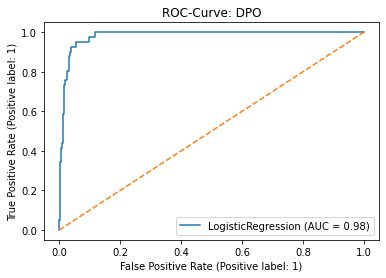

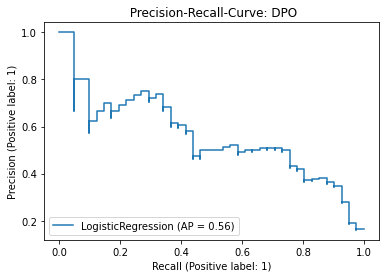

Confusion matrix DPO:
[[1752   47]
 [   8   33]]

Classification report DPO:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      1799
           1       0.41      0.80      0.55        41

    accuracy                           0.97      1840
   macro avg       0.70      0.89      0.77      1840
weighted avg       0.98      0.97      0.97      1840


TFIDF ROC_AUC Score 0.9825919548800824

Accuracy Score Before and After Thresholding: 0.970108695652174, 0.9445652173913044
Precision Score Before and After Thresholding: 0.4125, 0.2805755395683453
Recall Score Before and After Thresholding: 0.8048780487804879, 0.9512195121951219
F1 Score Before and After Thresholding: 0.5454545454545455, 0.43333333333333324
----------------------------------



Label in progress:Purpose
Ngram: (1, 3)


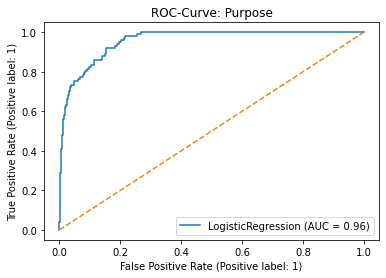

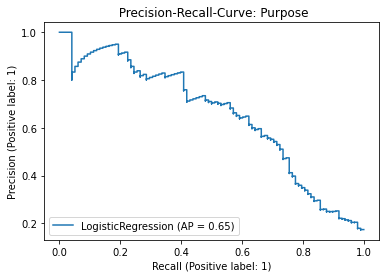

Confusion matrix Purpose:
[[1652   90]
 [  24   74]]

Classification report Purpose:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      1742
           1       0.45      0.76      0.56        98

    accuracy                           0.94      1840
   macro avg       0.72      0.85      0.77      1840
weighted avg       0.96      0.94      0.95      1840


TFIDF ROC_AUC Score 0.9564657091309543

Accuracy Score Before and After Thresholding: 0.9380434782608695, 0.7961956521739131
Precision Score Before and After Thresholding: 0.45121951219512196, 0.2046908315565032
Recall Score Before and After Thresholding: 0.7551020408163265, 0.9795918367346939
F1 Score Before and After Thresholding: 0.5648854961832062, 0.3386243386243386
----------------------------------



Label in progress:Acquired data
Ngram: (1, 3)


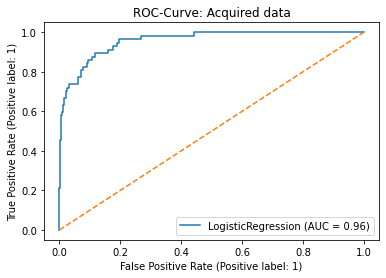

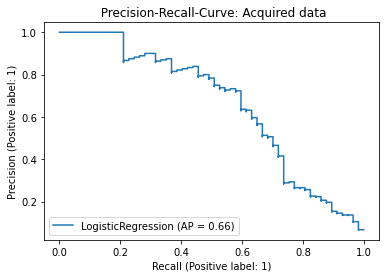

Confusion matrix Acquired data:
[[1743   40]
 [  17   40]]

Classification report Acquired data:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1783
           1       0.50      0.70      0.58        57

    accuracy                           0.97      1840
   macro avg       0.75      0.84      0.78      1840
weighted avg       0.98      0.97      0.97      1840


TFIDF ROC_AUC Score 0.9578868652281292

Accuracy Score Before and After Thresholding: 0.9690217391304348, 0.883695652173913
Precision Score Before and After Thresholding: 0.5, 0.1969111969111969
Recall Score Before and After Thresholding: 0.7017543859649122, 0.8947368421052632
F1 Score Before and After Thresholding: 0.583941605839416, 0.3227848101265823
----------------------------------



Label in progress:Data sharing
Ngram: (1, 3)


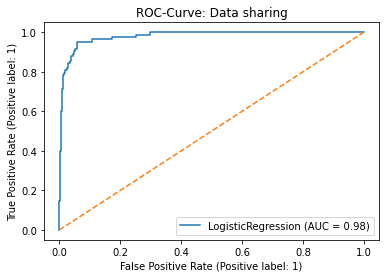

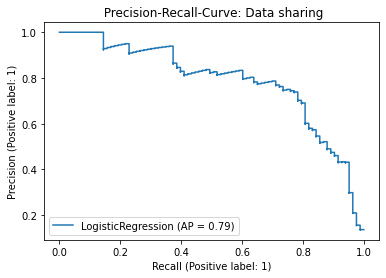

Confusion matrix Data sharing:
[[1702   55]
 [  13   70]]

Classification report Data sharing:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1757
           1       0.56      0.84      0.67        83

    accuracy                           0.96      1840
   macro avg       0.78      0.91      0.83      1840
weighted avg       0.97      0.96      0.97      1840


TFIDF ROC_AUC Score 0.9803608286304011

Accuracy Score Before and After Thresholding: 0.9630434782608696, 0.941304347826087
Precision Score Before and After Thresholding: 0.56, 0.43169398907103823
Recall Score Before and After Thresholding: 0.8433734939759037, 0.9518072289156626
F1 Score Before and After Thresholding: 0.6730769230769231, 0.5939849624060151
----------------------------------



Label in progress:Rights
Ngram: (1, 1)


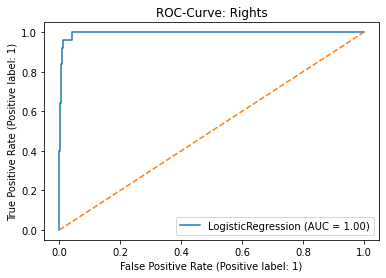

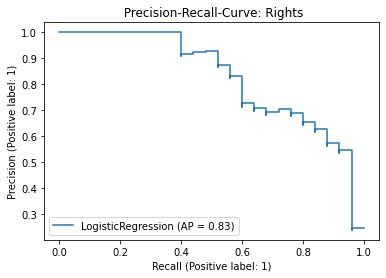

Confusion matrix Rights:
[[1795   20]
 [   2   23]]

Classification report Rights:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1815
           1       0.53      0.92      0.68        25

    accuracy                           0.99      1840
   macro avg       0.77      0.95      0.84      1840
weighted avg       0.99      0.99      0.99      1840


TFIDF ROC_AUC Score 0.9959669421487602

Accuracy Score Before and After Thresholding: 0.9880434782608696, 0.9586956521739131
Precision Score Before and After Thresholding: 0.5348837209302325, 0.24752475247524752
Recall Score Before and After Thresholding: 0.92, 1.0
F1 Score Before and After Thresholding: 0.6764705882352942, 0.3968253968253968
----------------------------------





In [68]:
# params = [(1,1), (1,2), (1,1), (1,1), (1,1)] # stemming + stopwords + ngrams
# params = [(1,1), (1,1), (1,1), (1,1), (1,1)] # stemming + ngrams
# params = [(1,1), (1,1), (1,1), (1,1), (1,1)] # lemmatizing + ngrams
# params = [(3,3), (3,3), (3,3), (3,3), (1,2)] # stemming + ngrams
# params = [(1,2), (1,2), (2,2), (2,2), (1,2)] # stemming + ngrams
# params = [(1,2), (1,3), (1,3), (1,3), (1,1)] # stemming + ngrams + oversampling
params = [(1,2), (1,3), (1,3), (1,3), (1,1)] # stemming + ngrams + oversampling + score:roc_auc
# params = [(1,2), (1,3), (1,2), (1,3), (1,2)] # stemming + ngrams + oversampling + score:roc_auc

for i, category in enumerate(categ):
    print("Label in progress:" + category)
    print("Ngram:", params[i])
    
    # initalise the vectorizer 
#     vectorizer = TfidfVectorizer(max_df = .75, min_df = .05, ngram_range = (1,2))
    vectorizer = TfidfVectorizer(ngram_range = params[i])


    x_train = preprocessing(train_data_text[i])
    x_test = preprocessing(test_data_text[i])
    
    x_train = vectorizer.fit_transform(x_train)
    x_test = vectorizer.transform(x_test)
    
    y_train = train_data[i]
    y_test = test_data[i]

    x_train, y_train = oversample_data(x_train, y_train)
    
    # Make an instance of the Model
    # all parameters not specified are set to their defaults
    lr = LogisticRegression(max_iter = 100)

    # Train the model on the data, storing the information learned from the data
    # Model is learning the relationship between digits (x_train) and labels (y_train)
    
    lr.fit(x_train, y_train)
        
    # Save to file in the current working directory
#     lr_file = "linreg-" + category + ".pkl"
#     lr_file = "linreg-oversampling-" + category + ".pkl"
#     with open(lr_file, 'wb') as file:
#         pickle.dump((vectorizer, lr), file)
    
    
    # Let's see what are the possible labels to predict (and in which order they are stored)
#     print(lr.classes_)

    # We can get additional information about all the parameters used with LogReg model
#     print(lr.get_params())

    y_pred = lr.predict(x_test)
    y_prob = lr.predict_proba(x_test)[:,1]
    roc_predictions = opt_threshold_roc(y_test, y_prob)
    
    # Plot self-made precision recall lines
#     cutoff_x = plot_cutoff(y_test, y_prob, False)
#     y_pred_o = [1 if i > cutoff_x[0] else 0 for i in y_prob]
    
    # plot ROC Curve
    metrics.plot_roc_curve(lr, x_test, y_test)  
    plt.title('ROC-Curve: ' + category)
    plt.plot([0,1], [0,1], linestyle="--") # plot random curve
    plt.show() 
    
    # Plot precision recall curve
    plot_precision_recall_curve(lr, x_test, y_test)
    plt.title(' Precision-Recall-Curve: ' + category)
    plt.show() 
    
    words = vectorizer.get_feature_names()

#     print()
#     print("Most important features:")
#     for label, coefs, intercept in zip(lr.classes_, lr.coef_, lr.intercept_):
#         print(label)
#         sort_zipped_list = sorted(zip(words, coefs), key = lambda x: x[1], reverse = True) 
#         for t, c in list(sort_zipped_list)[:10]:
#             print(t, c)
#         print("...")
#         print("INTERCEPT:" +str(intercept))
#         print("...")
#         for t, c in list(sort_zipped_list)[-10:]:
#             print(t, c)
#         print()
#         print()
        
    print("Confusion matrix " + category + ":")
    print(confusion_matrix(y_test, y_pred))
    print()
    print("Classification report " + category + ":")
    print(classification_report(y_test, y_pred))
#     print(classification_report(y_test, y_pred, labels = [1]))
    print()    

    
    print("TFIDF ROC_AUC Score", roc_auc_score(y_test, y_prob))
    print()    

#     if(cutoff_x[0] != 0.5):
#         print("Confusion matrix with cut-off point = ", cutoff_x[0]," :")
#         print(confusion_matrix(y_test, y_pred_o))
#         print()
#         print("Classification reportwith cut-off point = ", cutoff_x[0]," :")
#         print(classification_report(y_test, y_pred_o))
    
    print("Accuracy Score Before and After Thresholding: {}, {}".format(accuracy_score(y_test, y_pred), accuracy_score(y_test, roc_predictions)))
    print("Precision Score Before and After Thresholding: {}, {}".format(precision_score(y_test, y_pred), precision_score(y_test, roc_predictions)))
    print("Recall Score Before and After Thresholding: {}, {}".format(recall_score(y_test, y_pred), recall_score(y_test, roc_predictions)))
    print("F1 Score Before and After Thresholding: {}, {}".format(f1_score(y_test, y_pred), f1_score(y_test, roc_predictions)))
    
    
    print("----------------------------------")
    print()
    print()
    print()

### Background: performance metrics

### Accuracy ### 
For label X, accuracy is the number of correctly predicted labels divided by all labels<br>

\begin{align}
Accuracy(p) = \frac{correctly\ predicted\ as\ label\ A}{all\ predictions\ made} = \frac{true\ positives\ +\ true\ negatives}{true\ positives\ +\ false\ positives\ +\ true\ negatives\ +\ false\ negatives} \\
\end{align}

true positive = correctly predicted as label A<br>
false positive = incorrectly predicted as label A<br>
true negative = correctly predicted as not label A<br>
false negative = predicted as another label, whereas it is actually label A

- ___Is not very helpful in case of class imbalance (classifying everything to the majority class will result in this case in a good accuracy)___


### Precision ### 
For label X, precision is the number of correctly predicted labels __out of all predicted labels__ (for the actual label X) (What percent of the predicted labels are correct? The focus is on predictions.).<br>

\begin{align}
Precision(p) = \frac{correctly\ predicted\ as\ label\ A}{all\ predictions\ made\ as\ label\ A} = \frac{true\ positives}{true\ positives\ +\ false\ positives} \\
\end{align}

true positive = correctly predicted as label A<br>
false positive = incorrectly predicted as label A<br>


### Recall ### 
For label X, recall is the number of correctly predicted labels (same as above) __out of the number of actual labels A__ (Out of all actual label A's, what percent of them did the model predict correctly? The focus is on actual labels.).<br>
In other words: r = true positives / (true positives + false negatives)

\begin{align}
Recall(r) = \frac{correctly\ predicted\ as\ label\ A}{all\ actual\ items\ with\ label\ A} = \frac{true\ positives}{true\ positives\ +\ false\ negatives} \\
\end{align}

true positive = correctly predicted as label A<br>
false negative = predicted as another label, whereas it is actually label A

### F1 Score ###
Ok so precision and recall measures the performance of a model from two different perspectives.
We can combine the two measures to get a single, balanced score, which is also called __F1 score__.
Obtaining a single score is often easier to compare different models.

\begin{align}
F1 = 2 * \frac{Precision * Recall}{Precision + Recall} \\
\end{align}


### Receiver Operating Characteristic Curve (ROC) ###
An ROC curve (or receiver operating characteristic curve) is a plot that summarizes the performance of a binary classification model on the positive class. It is a probability curve that plots the TPR against FPR at various threshold values and essentially separates the ‘signal’ from the ‘noise’: the x-axis indicates the False Positive Rate and the y-axis indicates the True Positive Rate.
- ROC Curve: Plot of False Positive Rate (x) vs. True Positive Rate (y).
    - __True Positive Rate (Sensivity)__ = True Positives / (True Positives + False Negatives)
        - What proportion of the positives was correctly classified
    - __False Positive Rate (1- Specificity)__ = False Positives / (False Positives + True Negatives)

We can think of the plot as the fraction of correct predictions for the positive class (y-axis) versus the fraction of errors for the negative class (x-axis).

Ideally, we want the fraction of correct positive class predictions to be 1 (top of the plot) and the fraction of incorrect negative class predictions to be 0 (left of the plot). This highlights that the best possible classifier that achieves perfect skill is the top-left of the plot (coordinate 0,1).
- Perfect Skill: A point in the top left of the plot.

Source: https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-imbalanced-classification/

#### Area Under the Curve (AUC) 
The Area Under the Curve (AUC) is the measure of the ability of a classifier to distinguish between classes and is used as a summary of the ROC curve.
_The higher the AUC, the better the performance of the model at distinguishing between the positive and negative classes._
- When AUC = 1, then the classifier is able to perfectly distinguish between all the Positive and the Negative class points correctly. 
- If, however, the AUC had been 0, then the classifier would be predicting all Negatives as Positives, and all Positives as Negatives.
- When 0.5<AUC<1, there is a high chance that the classifier will be able to distinguish the positive class values from the negative class values.
- When AUC=0.5, then the classifier is not able to distinguish between Positive and Negative class points. Meaning either the classifier is predicting random class or constant class for all the data points

Source: 
- https://www.analyticsvidhya.com/blog/2020/06/auc-roc-curve-machine-learning/
- https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0118432

#### Imbalanced Data
If number of TN is high, x-axis in ROC which has TN in denominator (FPR) will be a very small number. As a consequence the ROC plot will be pushed to the left side which implies, misleadingly, that the classifier is performing well as the AUC is close to 1.

For this reason, it is better to use the Precision-Recall Curve as it doesn't use TN.

### Precision-Recall Curve
The precision-recall curve shows the tradeoff between precision and recall for different threshold. A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate. High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall).

A system with high recall but low precision returns many results, but most of its predicted labels are incorrect when compared to the training labels. A system with high precision but low recall is just the opposite, returning very few results, but most of its predicted labels are correct when compared to the training labels. An ideal system with high precision and high recall will return many results, with all results labeled correctly.

#### Area Under the Curve (Average precision (AP)) 
Average precision (AP) summarizes such a plot as the weighted mean of precisions achieved at each threshold, with the increase in recall from the previous threshold used as the weight.

Source: https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html

### Classification report ###
- __macro avg__: Calculate precision, recall and f1 metrics for each label, and find their average. This does not take label imbalance into account: f1 scores are averaged (with equal weights)
- __weighted avg__: Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). This alters "macro" to account for label imbalance (it can result in an F-score that is not between precision and recall).

### Confusion matrix ###

| |Actual|label|
|---|---|---|
|Predicted| TN | FP |
|label| FN | TP |

## Evaluate

### Performance (Logistic Regression) (optimalized based on ROC-AUC)
|Label|Approach|Precision|Recall|F1|AUC|
|:---:|:---|:---:|:---:|:---:|:---:|
|DPO|stemming + oversampling + ngram(1,2)|0.41|0.80|0.55|0.982|
|Purpose|stemming + oversampling + ngram(1,3)|0.45|0.76|0.56|0.956|
|Acquired data|stemming + oversampling + ngram(1,3)|0.50|0.70|0.58|0.958|
|Data sharing|stemming + oversampling + ngram(1,3)|0.56|0.84|0.67|0.980|
|Rights|stemming + oversampling + ngram(1,1)|0.53|0.92|0.68|0.996|

### Performance (Logistic Regression) (optimalized based on F1-Score)
|Label|Approach|Precision|Recall|F1|AUC|
|:---:|:---|:---:|:---:|:---:|:---:|
|DPO|stemming + oversampling + ngram(1,2)|0.41|0.80|0.55|0.982|
|Purpose|stemming + oversampling + ngram(1,3)|0.45|0.76|0.56|0.956|
|Acquired data|stemming + oversampling + ngram(1,3)|0.50|0.70|0.58|0.958|
|Data sharing|stemming + oversampling + ngram(1,3)|0.56|0.84|0.67|0.980|
|Rights|stemming + oversampling + ngram(1,1)|0.53|0.92|0.68|0.996|

### Most important features (optimalized based on ROC-AUC)
|DPO|Purpose|Acquired data|Data sharing|Rights|
|:---|:---|:---|:---|:---|
|contact| to | name | share | delet |
|offic| purpos | collect  | disclos | correct |
|at| use | address | parti | remov |
|pleas| and | detail | transfer | erasur |
|email| for | record | third | eras |
|telephon| use your | include | third parti | forgotten |
|us at| our | and | with | rectif |
|ico| you | health | share your | amend |
|post| administ | photograph | inform with | rectifi |
|data protect| use your person | pass | will never | incorrect |


----------------------------
### OLD
|Label|Approach|Precision|Recall|F1|AUC|
|:---:|:---|:---:|:---:|:---:|:---:|
|DPO|stemming + stopwords removal + ngram(1,1)|0.81 (0.98)|0.67 (0.97)|0.72 (0.98)|0.973|
|DPO|stemming + ngram(1,1)|0.79 (0.98)|0.68 (0.98)|0.72 (0.98)|0.977|
|DPO|oversampling + stemming + ngram(1,1)|0.67 (0.98)|0.88 (0.96)|0.73 (0.97)|0.980|
|Purpose|stemming + stopwords removal + ngram(1,2)|0.88 (0.95)|0.60 (0.95)|0.65 (0.94)|0.943|
|Purpose|stemming + ngram(1,2)|0.83 (0.94)|0.61 (0.95)|0.66 (0.94)|0.936|
|Purpose|oversampling + stemming + ngram(1,2)|0.65 (0.95)|0.86 (0.90)|0.70 (0.92)|0.934|
|Acquired data|stemming + stopwords removal + ngram(1,1)|0.96 (0.98)|0.63 (0.98)|0.70 (0.97)|0.931|
|Acquired data|stemming + ngram(1,1)|0.93 (0.97)|0.63 (0.98)|0.70 (0.97)|0.942|
|Acquired data|oversampling + stemming + ngram(1,1)|0.64 (0.97)|0.79 (0.94)|0.69 (0.95)|0.930|
|Data sharing|stemming + stopwords removal + ngram(1,1)|0.87 (0.96)|0.67 (0.97)|0.73 (0.96)|0.970|
|Data sharing|stemming + ngram(1,1)|0.87 (0.96)|0.70 (0.97)|0.75 (0.96)|0.973|
|Data sharing|oversampling + stemming + ngram(1,1)|0.75 (0.97)|0.93 (0.96)|0.81 (0.96)|0.975|
|Rights|stemming + stopwords removal + ngram(1,1)|0.95 (0.99)|0.68 (0.99)|0.75 (0.99)|0.992|
|Rights|stemming + ngram(1,1)|0.95 (0.99)|0.70 (0.99)|0.78 (0.99)|0.993|
|Rights|oversampling + stemming + ngram(1,1)|0.77 (0.99)|0.95 (0.99)|0.84 (0.99)|0.996|

# Analysis

|DPO (1799N, 41P)| Predicted N | Predicted P | | Predicted N | Predicted P |
|:---:|:---:|:---:|:---:|:---:|:---:|
| Actual N | 1794 | 5 | -> | 1752 | 47 |
| Actual P | 28 | 13 | -> | 8 | 33 |

- precision drops after oversampling
    - this is due the increase of false positives
- recall increases after oversampling
    - due to the decrease of false negatives 
    
#### Adjust cut-off point (we use default=0.5)
Introducing special thresholds only affects in the proportion of false positives/false negatives, and thus in precision/recall tradeoff, but it is not the parameter of the LR model. 

Source: 
- https://stackoverflow.com/questions/53846943/sklearn-logistic-regression-adjust-cutoff-point
- https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#sphx-glr-auto-examples-model-selection-plot-precision-recall-py
- https://www.kaggle.com/dstuerzer/optimized-logistic-regression
- https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/
- https://github.com/aldwin160/python/blob/master/finding%20the%20intersection%20of%20two%20curves.py (intersection of 2 curves using Shapely)
- https://medium.com/swlh/determining-a-cut-off-or-threshold-when-working-with-a-binary-dependent-target-variable-7c2342cf2a7c

## Focus on Recall or Precision?
- Precision: appropriate when minimizing false positives is the focus
- Recall: appropriate when minimizing false negatives is the focus

We are focusing on precision because we aim to minimize false positives. We consider false positives to be a bigger problem than false negatives, because a false positive will give us the incorrect impression that a privacy policy covers a particuler GDPR-requirement (e.g. mentioning DPO).

Source: https://machinelearningmastery.com/precision-recall-and-f-measure-for-imbalanced-classification/


#### How many sentences do we need to identify one positive sentence (without oversampling)?
Let us use a precision threshold of 90%: __how many sentences do we need to identify a true positive sentence with 90% precision?__

_Example:_

|DPO (1760N, 80P)| Predicted N | Predicted P |
|:---:|:---:|:---:|
| Actual N | 1752 | 47 |
| Actual P | 8 | 33 |


\begin{align} 
P(P\ sen.\ is\ TP) = \frac{33}{47 + 33} = 0.41 \\
P(P\ sen.\ is\ FP) = 1 - 0.41 = 0.59 \\
P(4\ P\ sen.\ are\ FP) = 0.59^4 \approx 0.121 \\
P(at\ least\ one\ sen.\ in\ 4\ P\ sen.\ is\ TP) \approx 1 - 0.121 \approx 0.88 
\end{align}

|Label| Precision | #positive sen. = 1 (= 1/1840 %)| #positive sen. = 4 (= 4/1840 %)|  #positive sen. = 5 (= 5/1840 %)|
|:---|:---|:---|:---|:---|
| DPO | 33 / (47 + 33) = 0.41 | \begin{align} P(P\ sen.\ is\ TP) = 0.41 \end{align}| \begin{align} P(one\ in\ 4\ P\ sen.\ is\ TP) \approx 0.88 \end{align}| \begin{align} P(one\ in\ 5\ P\ sen.\ is\ TP) \approx 0.93 \end{align}|
| Purpose | 74 / (90 + 74) = 0.45 | \begin{align} P(P\ sen.\ is\ TP) = 0.45 \end{align} |  \begin{align} P(one\ in\ 4\ P\ sen.\ is\ TP) \approx 0.95 \end{align}| \begin{align} P(one\ in\ 5\ P\ sen.\ is\ TP) \approx 0.95 \end{align}|
| Acquired Data | 40 / (40 + 40) = 0.50 | \begin{align} P(P\ sen.\ is\ TP) = 0.50 \end{align} | \begin{align} P(one\ in\ 4\ P\ sen.\ is\ TP) \approx 0.94 \end{align} | \begin{align} P(one\ in\ 5\ P\ sen.\ is\ TP) \approx 0.97 \end{align}|
| Data Sharing | 70 / (55 + 70) = 0.56 | \begin{align} P(P\ sen.\ is\ TP) = 0.56 \end{align} | \begin{align} P(one\ in\ 4\ P\ sen.\ is\ TP) \approx 0.96 \end{align}| \begin{align} P(one\ in\ 5\ P\ sen.\ is\ TP) \approx 0.98\end{align}|
| Rights | 23 / (20 + 23) = 0.53 | \begin{align} P(P\ sen.\ is\ TP) = 0.53 \end{align} | \begin{align} P(one\ in\ 4\ P\ sen.\ is\ TP) \approx 0.95 \end{align}| \begin{align} P(one\ in\ 5\ P\ sen.\ is\ TP) \approx 0.98 \end{align}|

## Predict collected dataset of scraped SME policies

In [23]:
# thresholds
# sen_thresh = [2, 2, 1, 2, 2]
#without sen_thresh = [1, 1, 1, 1, 1]
threshold = (5/1840)

In [43]:
# dataset_sme = pandas.read_csv('data/SME/SME-GDPR-test.csv', sep='\t', encoding='utf-8')
# dataset_sme

# import necessary libraries
import pandas as pd
import os
import glob
import math
import numpy
  
scores_sme = numpy.zeros((5, 1000))    
sme_length_list = []

# use glob to get all the csv files 
# in the folder
path = 'data\SME'
csv_files = glob.glob(os.path.join(path, "*.csv"))
  
print(len(csv_files))  
# loop over the list of csv files
for j, f in enumerate(csv_files):
    print("This is file: ", j, "of ", len(csv_files))
    
    df_sme = pandas.read_csv(f, sep='\t', encoding='utf-8')
    test_text, test_dpo, test_purpose, test_acquired_data, test_data_sharing, test_rights, test_nocat = get_data(df_sme)
    sme_test_data = [test_dpo, test_purpose, test_acquired_data, test_data_sharing, test_rights, test_nocat]
    print("Length: ", len(test_text))
    
    sme_length_list.append(len(test_text))
    
    abs_thres = math.ceil(threshold*len(test_text))
    print("We need ", abs_thres, "P sentences to find at least 1 TP with precision of > 90%")
    
    for i, category in enumerate(categ):
         # Load from file to check if everything is ok
#         filen = "linreg-oversampling-" + category + ".pkl"      
        filen = "linreg-oversampling-" + category + ".pkl"      
        with open(filen, 'rb') as file:
            vectorizer, lr = pickle.load(file)

#         print("* Label = ", category)

        x_test = preprocessing(test_text)
        x_test = vectorizer.transform(x_test)

        y_test = sme_test_data[i]
        y_pred = lr.predict(x_test)
        
#         if (category == "DPO"):
#             print("# 1s: ", list(y_pred).count(1))
#             print("threshold: ", sen_thresh[i])
        
#         if list(y_pred).count(1) >= sen_thresh[i]:
        if list(y_pred).count(1) >= abs_thres:
            scores_sme[i][j] = 1
#             if (category == "DPO"):
#                 print("#BINGO")

    print()

1000
This is file:  0 of  1000
Length:  23
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is file:  1 of  1000
Length:  29
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is file:  2 of  1000
Length:  96
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is file:  3 of  1000
Length:  57
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is file:  4 of  1000
Length:  19
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is file:  5 of  1000
Length:  53
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is file:  6 of  1000
Length:  62
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is file:  7 of  1000
Length:  73
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is file:  8 of  1000
Length:  101
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is file:  9 of  1


This is file:  76 of  1000
Length:  77
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is file:  77 of  1000
Length:  169
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is file:  78 of  1000
Length:  37
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is file:  79 of  1000
Length:  72
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is file:  80 of  1000
Length:  66
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is file:  81 of  1000
Length:  92
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is file:  82 of  1000
Length:  171
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is file:  83 of  1000
Length:  50
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is file:  84 of  1000
Length:  62
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is file:  8


This is file:  151 of  1000
Length:  134
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is file:  152 of  1000
Length:  41
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is file:  153 of  1000
Length:  93
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is file:  154 of  1000
Length:  190
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is file:  155 of  1000
Length:  193
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is file:  156 of  1000
Length:  61
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is file:  157 of  1000
Length:  99
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is file:  158 of  1000
Length:  77
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is file:  159 of  1000
Length:  65
We need  1 P sentences to find at least 1 TP with precision of > 90%

This i


This is file:  226 of  1000
Length:  23
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is file:  227 of  1000
Length:  92
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is file:  228 of  1000
Length:  43
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is file:  229 of  1000
Length:  20
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is file:  230 of  1000
Length:  87
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is file:  231 of  1000
Length:  106
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is file:  232 of  1000
Length:  193
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is file:  233 of  1000
Length:  77
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is file:  234 of  1000
Length:  52
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is


This is file:  301 of  1000
Length:  351
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is file:  302 of  1000
Length:  103
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is file:  303 of  1000
Length:  85
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is file:  304 of  1000
Length:  22
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is file:  305 of  1000
Length:  39
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is file:  306 of  1000
Length:  288
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is file:  307 of  1000
Length:  84
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is file:  308 of  1000
Length:  53
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is file:  309 of  1000
Length:  161
We need  1 P sentences to find at least 1 TP with precision of > 90%

This 


This is file:  376 of  1000
Length:  32
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is file:  377 of  1000
Length:  96
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is file:  378 of  1000
Length:  77
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is file:  379 of  1000
Length:  77
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is file:  380 of  1000
Length:  47
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is file:  381 of  1000
Length:  493
We need  2 P sentences to find at least 1 TP with precision of > 90%

This is file:  382 of  1000
Length:  45
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is file:  383 of  1000
Length:  109
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is file:  384 of  1000
Length:  31
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is


This is file:  451 of  1000
Length:  57
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is file:  452 of  1000
Length:  107
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is file:  453 of  1000
Length:  61
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is file:  454 of  1000
Length:  60
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is file:  455 of  1000
Length:  23
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is file:  456 of  1000
Length:  152
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is file:  457 of  1000
Length:  113
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is file:  458 of  1000
Length:  127
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is file:  459 of  1000
Length:  103
We need  1 P sentences to find at least 1 TP with precision of > 90%

This


This is file:  526 of  1000
Length:  77
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is file:  527 of  1000
Length:  37
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is file:  528 of  1000
Length:  47
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is file:  529 of  1000
Length:  77
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is file:  530 of  1000
Length:  43
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is file:  531 of  1000
Length:  119
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is file:  532 of  1000
Length:  102
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is file:  533 of  1000
Length:  77
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is file:  534 of  1000
Length:  59
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is


This is file:  601 of  1000
Length:  132
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is file:  602 of  1000
Length:  97
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is file:  603 of  1000
Length:  120
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is file:  604 of  1000
Length:  199
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is file:  605 of  1000
Length:  73
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is file:  606 of  1000
Length:  43
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is file:  607 of  1000
Length:  144
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is file:  608 of  1000
Length:  21
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is file:  609 of  1000
Length:  208
We need  1 P sentences to find at least 1 TP with precision of > 90%

This


This is file:  676 of  1000
Length:  43
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is file:  677 of  1000
Length:  106
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is file:  678 of  1000
Length:  229
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is file:  679 of  1000
Length:  49
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is file:  680 of  1000
Length:  54
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is file:  681 of  1000
Length:  50
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is file:  682 of  1000
Length:  24
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is file:  683 of  1000
Length:  30
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is file:  684 of  1000
Length:  36
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is


This is file:  751 of  1000
Length:  73
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is file:  752 of  1000
Length:  104
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is file:  753 of  1000
Length:  21
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is file:  754 of  1000
Length:  88
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is file:  755 of  1000
Length:  37
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is file:  756 of  1000
Length:  99
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is file:  757 of  1000
Length:  24
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is file:  758 of  1000
Length:  109
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is file:  759 of  1000
Length:  80
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is


This is file:  826 of  1000
Length:  46
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is file:  827 of  1000
Length:  53
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is file:  828 of  1000
Length:  39
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is file:  829 of  1000
Length:  110
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is file:  830 of  1000
Length:  88
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is file:  831 of  1000
Length:  43
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is file:  832 of  1000
Length:  54
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is file:  833 of  1000
Length:  34
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is file:  834 of  1000
Length:  73
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is 


This is file:  901 of  1000
Length:  92
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is file:  902 of  1000
Length:  77
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is file:  903 of  1000
Length:  278
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is file:  904 of  1000
Length:  67
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is file:  905 of  1000
Length:  121
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is file:  906 of  1000
Length:  272
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is file:  907 of  1000
Length:  144
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is file:  908 of  1000
Length:  60
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is file:  909 of  1000
Length:  164
We need  1 P sentences to find at least 1 TP with precision of > 90%

This


This is file:  976 of  1000
Length:  107
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is file:  977 of  1000
Length:  352
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is file:  978 of  1000
Length:  77
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is file:  979 of  1000
Length:  86
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is file:  980 of  1000
Length:  96
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is file:  981 of  1000
Length:  27
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is file:  982 of  1000
Length:  64
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is file:  983 of  1000
Length:  77
We need  1 P sentences to find at least 1 TP with precision of > 90%

This is file:  984 of  1000
Length:  128
We need  1 P sentences to find at least 1 TP with precision of > 90%

This i

In [44]:
list(scores_sme[0]).count(1)/len(list(scores_sme[0]))

0.883

## Predict collected dataset of LE policies

In [48]:
# dataset_sme = pandas.read_csv('data/SME/SME-GDPR-test.csv', sep='\t', encoding='utf-8')
# dataset_sme

# import necessary libraries
import pandas as pd
import os
import glob
import numpy
  
scores_le = numpy.zeros((5, 1000))    
le_length_list = []
    
# use glob to get all the csv files 
# in the folder
path = 'data\LE'
csv_files = glob.glob(os.path.join(path, "*.csv"))
  
# loop over the list of csv files
for j, f in enumerate(csv_files):
    print("This is file: ", j, "of ", len(csv_files))
    
    df_le = pandas.read_csv(f, sep='\t', encoding='utf-8')
    test_text, test_dpo, test_purpose, test_acquired_data, test_data_sharing, test_rights, test_nocat = get_data(df_le)
    le_test_data = [test_dpo, test_purpose, test_acquired_data, test_data_sharing, test_rights, test_nocat]
    print("Length: ", len(test_text))
    
    le_length_list.append(len(test_text))
    
    abs_thres = math.ceil(threshold*len(test_text))
    print("We need ", abs_thres, "P sentences to find at least 1 TP with precision of > 90%")
    for i, category in enumerate(categ):
        
         # Load from file to check if everything is ok
        filen = "linreg-oversampling-" + category + ".pkl"      
        with open(filen, 'rb') as file:
            vectorizer, lr = pickle.load(file)

#         print("* Label = ", category)

        x_test = preprocessing(test_text)
        x_test = vectorizer.transform(x_test)

        y_test = le_test_data[i]
        y_pred = lr.predict(x_test)

#         if list(y_pred).count(1) >= sen_thresh[i]:
        if list(y_pred).count(1) >= abs_thres:
            scores_le[i][j] = 1
            
            idx = list(y_pred).index(1)
            print("* The following sentence is predicted as positive for category: ", category)
            print("- ", test_text[idx])
    print()

This is file:  0 of  1000
Length:  190
We need  1 P sentences to find at least 1 TP with precision of > 90%
* The following sentence is predicted as positive for category:  DPO
-  . email contact
* The following sentence is predicted as positive for category:  Purpose
-   general purposes of processing
* The following sentence is predicted as positive for category:  Acquired data
-  we process personal data that we need to fulfil the services that we provide, such as name, address, and email address.
* The following sentence is predicted as positive for category:  Data sharing
-  however, if ip anonymisation is enabled on this website, your ip address will first be truncated by google within the member states of the european union or other states party to the agreement on the european economic area.
* The following sentence is predicted as positive for category:  Rights
-  the existence of a right of rectification or erasure of personal data concerning them or of a restriction on proce

* The following sentence is predicted as positive for category:  Purpose
-  we use the information we collect and receive for the following general purposes:to provide you with the services, products, and information you request and with legal notices or information about changes to this privacy policy or our terms of useto continually improve the services and enhance your experience with the servicesto better understand your interests in order to provide you with relevant content, surveys and questionnaires, and other materials andto respond to your requests, questions, and commentsas we believe is necessary to protect our rights and the rights of others, including by enforcing our terms of use.
* The following sentence is predicted as positive for category:  Acquired data
-  collection of informationgenerally speaking, we collect or receive the following types of information when you use the services:information you provide directly.
* The following sentence is predicted as positive 

KeyboardInterrupt: 

## Results 

In [25]:
def get_data(df):
    test_text = df['Text'].to_list()
    test_dpo = df['DPO'].to_list()
    test_purpose = df['Purpose'].to_list()
    test_acquired_data = df['Acquired data'].to_list()
    test_data_sharing = df['Data sharing'].to_list()
    test_rights = df['Rights'].to_list()

    test_nocat_idx = df.index[((df['DPO'] == 0) & 
                             (df['Purpose'] == 0) & 
                             (df['Acquired data'] == 0) & 
                             (df['Data sharing'] == 0) & 
                             (df['Rights'] == 0))].tolist()

    test_nocat = []
    for i in range(len(df)):
        if i in test_nocat_idx:
            test_nocat.append(1)
        else:
            test_nocat.append(0)
            
    return test_text, test_dpo, test_purpose, test_acquired_data, test_data_sharing, test_rights, test_nocat

In [38]:
def get_scores(inp_str, scores):
    print(inp_str)
    for i, category in enumerate(categ):
        sc = (list(scores[i]).count(1) / len(scores[i])) * 100
        print(category + " ", sc)
    print("")
    
def get_avg_score(inp_str, scores):
    print(inp_str + " average score over all policies")
    count_s = 0
    for i in range(len(list(scores[0]))):
        if scores[0][i] == scores[1][i] == scores[2][i] == scores[3][i] == scores[4][i] == 1:
            count_s = count_s + 1
    #     print(i)
    print((count_s / len(list(scores[0])))*100)
    print("")

In [45]:
# compute average length of privacy policies
average_sme = sum(sme_length_list) / len(sme_length_list)
average_le = sum(le_length_list) / len(le_length_list)
  
# Printing average of the list
print("Average length of privacy policies (SMEs):", round(average_sme, 2))
print("Average length of privacy policies (LEs):", round(average_le, 2))

Average length of privacy policies (SMEs): 91.63
Average length of privacy policies (LEs): 102.59


In [46]:
get_scores("SME", scores_sme)
get_scores("LE", scores_le)
get_avg_score("SME", scores_sme)
get_avg_score("LE", scores_le)

SME
DPO  88.3
Purpose  93.8
Acquired data  89.2
Data sharing  93.4
Rights  83.3

LE
DPO  84.6
Purpose  92.0
Acquired data  87.2
Data sharing  90.60000000000001
Rights  79.0

SME average score over all policies
69.6

LE average score over all policies
63.4



### Coverage of GDPR assessment criteria in 1000 privacy policies expressed in %.
- Average length SMEs: 92 sentences
- Average length LEs: 103 sentences

For each privacy policy we have assessed whether it complies with each and every one of the GDPR assessment criteria. If one of sentences in the document were considered as compliant with one of the criterium, the whole document was marked as compliant with that respective criterium.

__Threshold = (5/1840), gives precision > 90%__

|Label|	SME|LE|
|:---|:---:|:---:|
|DPO (1)| 88.3 | 84.6 |
|Purpose (1)| 93.8 | 92.0 |
|Acquired data (1)| 89.2 | 87.2 |
|Data Sharing (1)| 93.4 | 90.6 |
|Rights (1)| 83.3 | 79.0 |
|__All labels__|__69.6__|__63.4__|

***
***
***

# Optional: Multi-label approach (_in progress_)
#### MULTILABEL vs. Multiclass
- Multiclass classification is a classification task with more than two classes. Each sample can only be labeled as one class.
- ___Multilabel classification (closely related to multioutput classification) is a classification task labeling each sample with m labels from n_classes possible classes, where m can be 0 to n_classes inclusive. This can be thought of as predicting properties of a sample that are not mutually exclusive.___

Source: https://scikit-learn.org/stable/modules/multiclass.html

#### One-vs-the-rest (OvR) multiclass strategy.
Also known as one-vs-all, this strategy consists in fitting one classifier per class. For each classifier, the class is fitted against all the other classes. In addition to its computational efficiency (only n_classes classifiers are needed), one advantage of this approach is its interpretability. Since each class is represented by one and one classifier only, it is possible to gain knowledge about the class by inspecting its corresponding classifier. This is the most commonly used strategy for multiclass classification and is a fair default choice.

Source: https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html

In [111]:
from sklearn.datasets import make_classification
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.utils import shuffle
import numpy as np

In [215]:
# Source: https://towardsdatascience.com/multi-label-text-classification-with-scikit-learn-30714b7819c5

LogReg_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer()),
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)),
            ])
for category in categ:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
#     LogReg_pipeline.fit(X_train, train[category])
#     # compute the testing accuracy
#     prediction = LogReg_pipeline.predict(X_test)
#     print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))

... Processing DPO
... Processing Purpose
... Processing Acquired data
... Processing Data sharing
... Processing Rights
